# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

# Литература по теме и примеры найденные в интернете

http://web.cs.wpi.edu/~emmanuel/courses/cs528/F17/slides/papers/deepak_ganesan_GPS_clustering.pdf

http://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
https://github.com/gboeing/data-visualization/blob/master/location-history/google-location-history-cluster.ipynb

https://automating-gis-processes.github.io/2016/Lesson1-Intro-Python-GIS.html


Важно при чтении данных x = lon (это долгота), y = lat (это широта)
lat должна стоять на первом месте если будем пользоваться API или библиотеками работы с координатами



# Выбор стратегии кластеризации
## DBSCAN
1. Фильтруем данные через сводные таблицы и оставляем только уникальные GPS координаты и считаем число голосов (решено)
2. Алгоритм DBSCAN, критерий сегментации - расстояние в км между точками (решено)
3. сначала выберем небольшое расстояние метров 300-400 между объектами, нужно найти самые плотные кластеры. (самый плотный кластер не должен быть слишком большим) (решено)
4. определим центроиды в найденных кластерах (не сделано)
5. отфильтруем данные оставляем центроиды найденных кластеров и все остальное (не сделано).
6. далее задача продвигаться с минимальным шагом, 10м, точки должны прилипать к центроидам классов  (не сделано)

## K-means
1. Перебрать эвристикой число классов (100 - 180) (решено)


In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (12, 9)

import numpy as np
import pandas as pd

import time
import tqdm

# Читаем данные

In [2]:
!ls

atd                       geo_comment.xlsx          my_map.html
geo.xlsx                  homework clustering.ipynb


In [3]:
df = pd.read_excel('geo.xlsx', )

In [4]:
df.head()

,lon,lat,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108806 entries, 0 to 108805
Data columns (total 3 columns):
lon              108806 non-null float64
lat              108806 non-null float64
comment_class    108806 non-null int64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB


## Фильтруем уникальные значения и считаем голоса
делаем через сводные таблицы 

In [6]:
# сложим коориднаты, чтобы отфильтровать уникальные значения
df['coordinates'] = list((zip(df["lat"], df["lon"])))

In [7]:
list_uniq_coord = df['coordinates'].unique()

In [8]:
list_uniq_coord

array([(55.777454, 37.612416), (55.742108, 37.603298),
       (55.728758, 37.558526), ..., (55.633043, 37.67449),
       (55.630924, 37.670672), (55.773824, 37.490362)], dtype=object)

In [9]:
#сделаем сводную таблицу сгуппировав по уникальным координатам посчитаем число голосов
df_group_comment = df.groupby("coordinates")["comment_class"].value_counts()

In [10]:
#создадим новый датафрейм из сводной таблицы
df_gps = df_group_comment.to_frame('counts').reset_index() 


In [11]:
#разделим координаты для будущих операций
df_gps['lat'] = df_gps['coordinates'].apply(lambda x: list(x)[0] )
df_gps['lon'] = df_gps['coordinates'].apply(lambda x: list(x)[1] )


In [12]:
df_gps.head(2)

,coordinates,comment_class,counts,lat,lon
0,"(55.496939, 37.584829)",-1,32,55.496939,37.584829
1,"(55.498841, 37.592806)",-1,32,55.498841,37.592806


In [13]:
df_gps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2943 entries, 0 to 2942
Data columns (total 5 columns):
coordinates      2943 non-null object
comment_class    2943 non-null int64
counts           2943 non-null int64
lat              2943 non-null float64
lon              2943 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 115.0+ KB


### Немного поэксперементируем с GeoPandas

,NAME,OKATO,OKTMO,NAME_AO,OKATO_AO,ABBREV_AO,TYPE_MO,geometry
0,Киевский,45298555,45945000,Троицкий,45298000,Троицкий,Поселение,"(POLYGON ((36.8031012 55.4408329, 36.8031903 5..."
1,Филёвский Парк,45268595,45328000,Западный,45268000,ЗАО,Муниципальный округ,"POLYGON ((37.4276499 55.7482092, 37.4284863 55..."
2,Новофёдоровское,45298567,45954000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.8035692 55.4516224, 36.8045117 55..."
3,Роговское,45298575,45956000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.9372397 55.2413907, 36.9372604 55..."
4,"""Мосрентген""",45297568,45953000,Новомосковский,45297000,Новомосковский,Поселение,"POLYGON ((37.4395575 55.6273129, 37.4401803 55..."


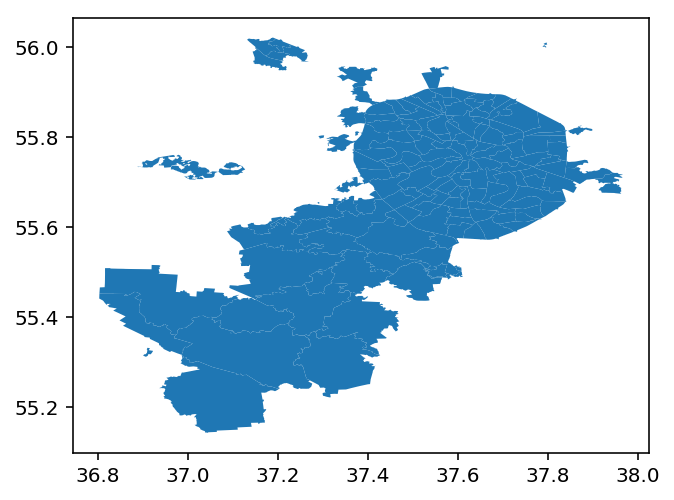

In [15]:
#https://habr.com/company/ods/blog/338554/
    
import geopandas as gpd
from shapely.geometry import Point
mo_gdf = gpd.read_file('atd/mo.shp')
mo_gdf.plot()
mo_gdf.head()


In [16]:
mo_gdf.head(2)

,NAME,OKATO,OKTMO,NAME_AO,OKATO_AO,ABBREV_AO,TYPE_MO,geometry
0,Киевский,45298555,45945000,Троицкий,45298000,Троицкий,Поселение,"(POLYGON ((36.8031012 55.4408329, 36.8031903 5..."
1,Филёвский Парк,45268595,45328000,Западный,45268000,ЗАО,Муниципальный округ,"POLYGON ((37.4276499 55.7482092, 37.4284863 55..."


In [17]:
#a = mo_gdf.geometry[0]
#print (a)

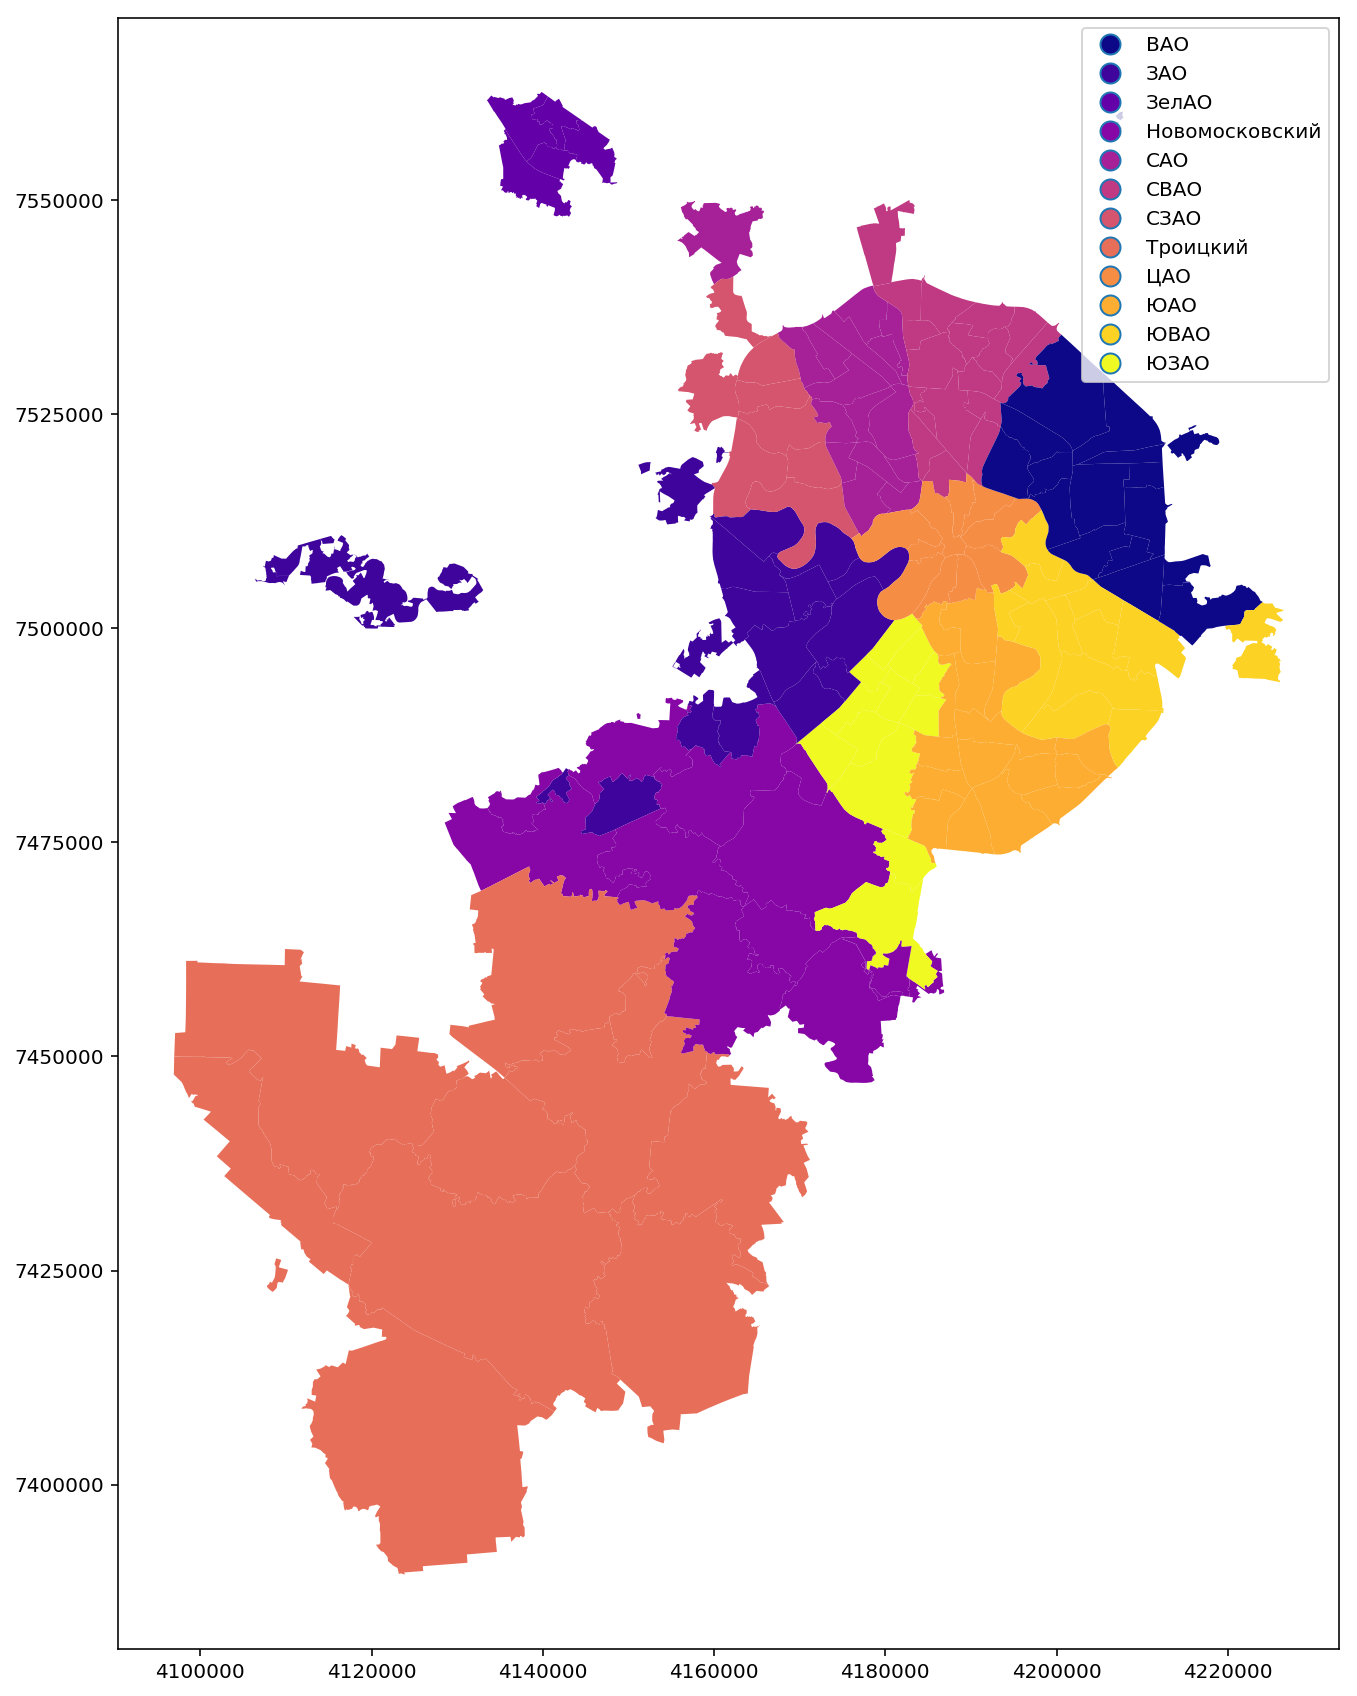

In [18]:
mo_gdf_wm = mo_gdf.to_crs({'init' :'epsg:3857'}) #непосредственно преобразование проекции
mo_gdf_wm.plot(column = 'ABBREV_AO', linewidth=0.5, cmap='plasma', legend=True, figsize=[15,15])

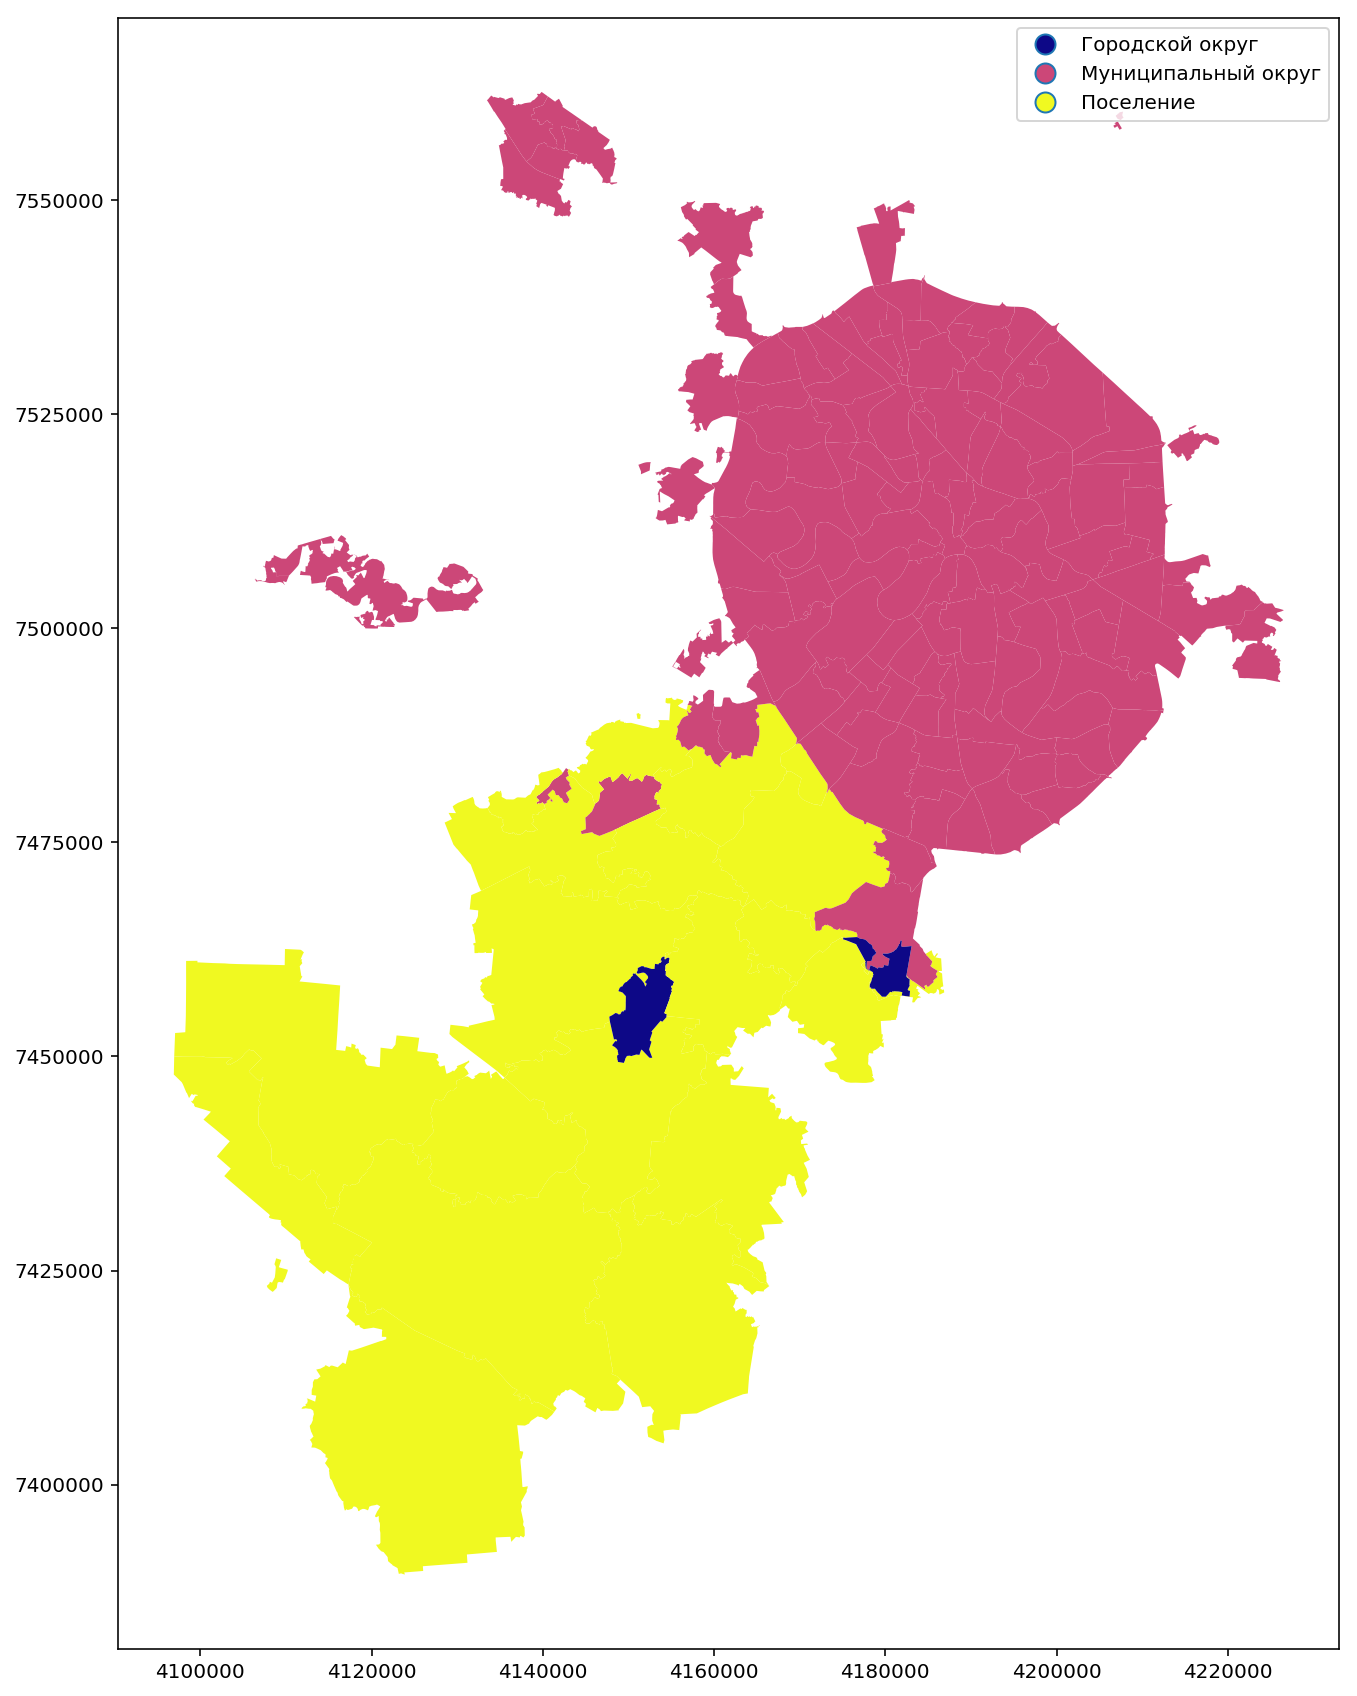

In [19]:
mo_gdf_wm.plot(column = 'TYPE_MO', linewidth=0.5, cmap='plasma', legend=True, figsize=[15,15])

In [20]:
#Функции для конвертации координат
#https://gist.github.com/sepulchered/6714835
import math

def epsg_4326_to_900913(lon, lat):
    '''
    IN: epsg_4326_to_900913 (37.73850110980581, 55.842864765698465)
    OUT: (4201030.726260184, 7527197.857521076)
    '''
    x = lon * 20037508.34 / 180
    y = (math.log(math.tan((90 + lat) * math.pi / 360)) / (math.pi / 180)) * (20037508.34 / 180)
    return x, y


def epsg_900913_to_4326(x, y):
    '''
    IN: epsg_900913_to_4326(4201030.726260184, 7527197.857521078)
    OUT (37.73850110980581, 55.842864765698465)   
    '''
    lon = x * 180 / 20037508.34
    lat = (360 / math.pi) * math.atan(math.exp(y * math.pi / 20037508.34)) - 90
    return lon, lat

In [21]:
#коряво вышло, но двигаемся дальше
df_gps['lon_new'] = df_gps['lon'].apply(lambda x: x * 20037508.34 / 180)

In [22]:
df_gps['lat_new'] = df_gps['lat'].apply(lambda y: (math.log(math.tan((90 + y) * math.pi / 360)) / (math.pi / 180)) * (20037508.34 / 180))

In [23]:
df_gps.head()

,coordinates,comment_class,counts,lat,lon,lon_new,lat_new
0,"(55.496939, 37.584829)",-1,32,55.496939,37.584829,4.183924e+06,7.458915e+06
1,"(55.498841, 37.592806)",-1,32,55.498841,37.592806,4.184812e+06,7.459289e+06
2,"(55.500422, 37.58782)",-1,32,55.500422,37.587820,4.184257e+06,7.459600e+06
3,"(55.505077, 37.589419)",-1,1,55.505077,37.589419,4.184435e+06,7.460515e+06
4,"(55.506898, 37.578298)",-1,67,55.506898,37.578298,4.183197e+06,7.460873e+06


In [24]:
# попробуем перевести координаты в формат геоданных
# встроенным методом почемуто не получилось, пришлось колхозить функции см выше
#https://gis.stackexchange.com/questions/174159/convert-a-pandas-dataframe-to-a-geodataframe
import shapely.wkt

gdf_gps = gpd.GeoDataFrame(df_gps,
                        crs={'init' :'epsg:3857'},
                        geometry=[shapely.geometry.Point(xy) \
                                  for xy in zip(df_gps.lon_new, df_gps.lat_new)])



In [25]:
gdf_gps.head()

,coordinates,comment_class,counts,lat,lon,lon_new,lat_new,geometry
0,"(55.496939, 37.584829)",-1,32,55.496939,37.584829,4.183924e+06,7.458915e+06,POINT (4183924.025249855 7458915.365541863)
1,"(55.498841, 37.592806)",-1,32,55.498841,37.592806,4.184812e+06,7.459289e+06,POINT (4184812.020827789 7459289.157907466)
2,"(55.500422, 37.58782)",-1,32,55.500422,37.587820,4.184257e+06,7.459600e+06,POINT (4184256.981846771 7459599.879182294)
3,"(55.505077, 37.589419)",-1,1,55.505077,37.589419,4.184435e+06,7.460515e+06,POINT (4184434.981712525 7460514.820405125)
4,"(55.506898, 37.578298)",-1,67,55.506898,37.578298,4.183197e+06,7.460873e+06,POINT (4183196.997655584 7460872.767772159)


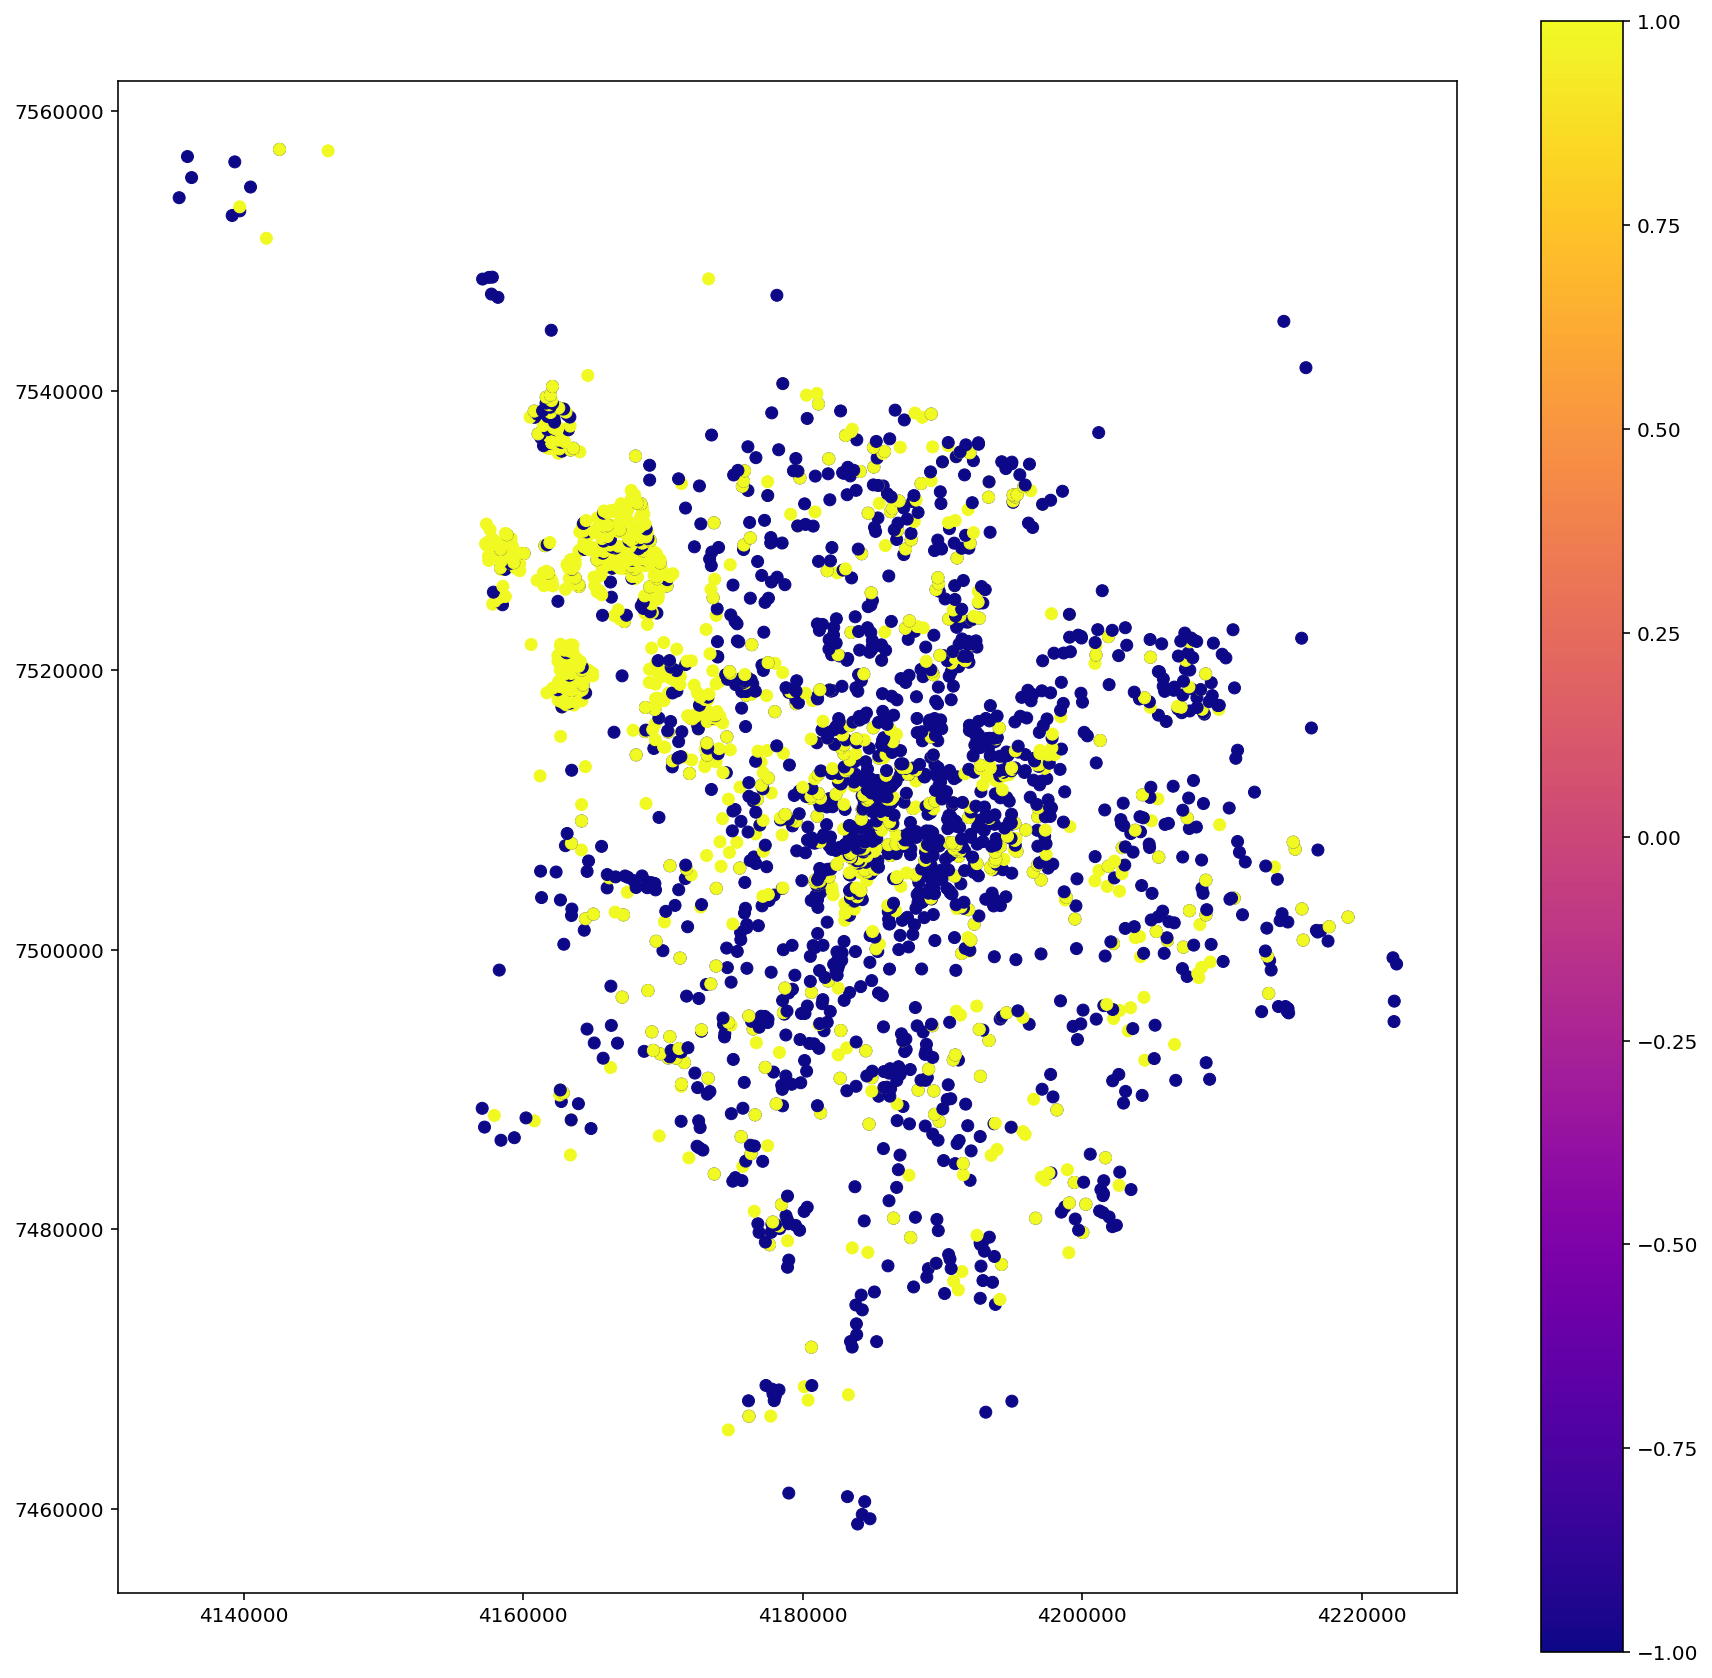

In [26]:
#первый раз осознал данные, концентрация в центре и разреженные по переферии 
gdf_gps.plot(column = 'comment_class', linewidth=0.5, cmap='plasma', legend=True, figsize=[15,15])

# Привяжем точки к полигонам, посмотрим как прошло голосование

In [27]:
#проверим точки принадлежащие полигону
#https://automating-gis-processes.github.io/2016/Lesson3-point-in-polygon.html

from geopandas.geoseries import *
from shapely.geometry import Point, Polygon


In [28]:
#geopandas за проверку принадлежности отвечает конструкция my_point.within(my_poligon)
#точки записаны не в формате GPS!

points_poly =[]
gps_coord = []
votes = []
number_votes = []

for i in tqdm.tqdm(range(0, mo_gdf_wm.shape[0])):
    poly = mo_gdf_wm['geometry'][i]
    for k in range(0, gdf_gps.shape[0]):
        p2 = gdf_gps['geometry'][k]
        if p2.within(poly) is True:
            #gdf_gps['poly'][k] = poly.
            points_poly.append(poly)
            gps_coord.append(p2)
            votes.append(gdf_gps['comment_class'][k])
            number_votes.append (gdf_gps['counts'][k])

100%|██████████| 146/146 [00:13<00:00, 11.10it/s]


In [29]:
gdf_poly_votes = gpd.GeoDataFrame(votes, columns=['votes'])


In [30]:
gdf_poly_votes['geometry'] = points_poly
gdf_poly_votes['number_votes'] = number_votes

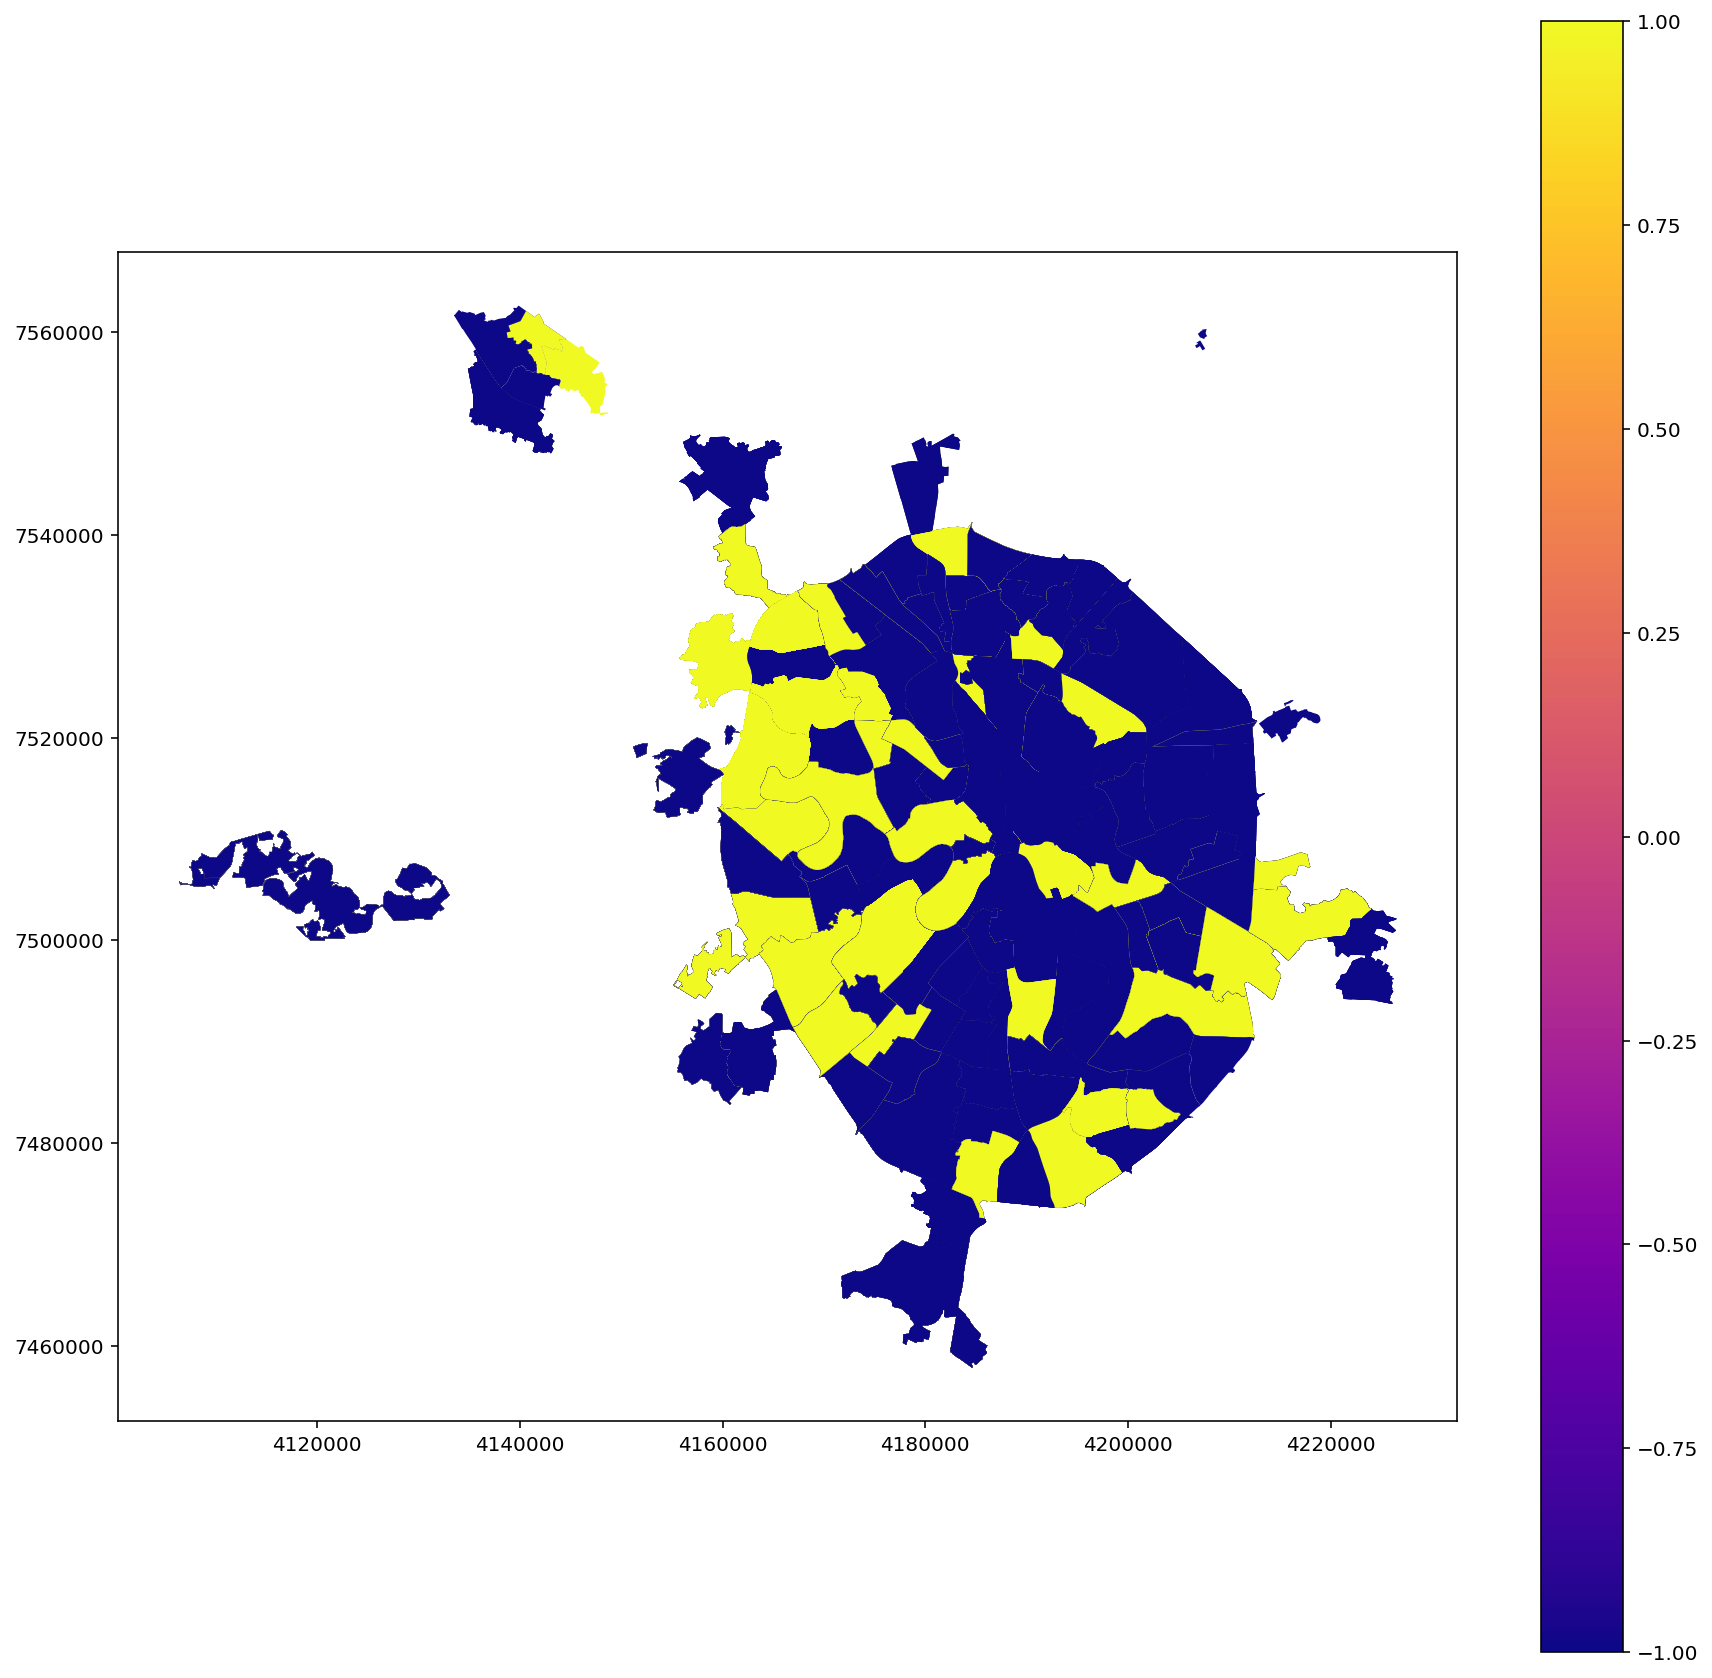

In [31]:
#получилась карта районов с преобладанием голосов
gdf_poly_votes.plot(column = 'votes', linewidth=0.5, cmap='plasma', legend=True, figsize=[15,15])

# Теперь займемся кластеризацией без известных данных районов

In [32]:
#http://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
#https://github.com/gboeing/data-visualization/blob/master/location-history/google-location-history-cluster.ipynb

#подобрать параметры не смог, данные в центре очень плотные и разреженные на переферии

from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

kms_per_radian = 6371.0088
epsilon = 0.300 / kms_per_radian

coords = gdf_gps.as_matrix(columns=['lat', 'lon'])

db = DBSCAN(eps=epsilon, 
            min_samples=6, 
            algorithm='ball_tree', 
            metric='haversine').fit(np.radians(coords))

In [33]:
%%time
cluster_labels = db.labels_
#num_clusters = len(set(cluster_labels))

# Number of clusters in labels, ignoring noise if present.
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

print('Number of clusters: {:,}'.format(num_clusters))
print('Adding lables to dataset...')

gdf_gps['cluster_number']  = cluster_labels

Number of clusters: 74
Adding lables to dataset...
CPU times: user 1.05 ms, sys: 158 µs, total: 1.21 ms
Wall time: 1.13 ms


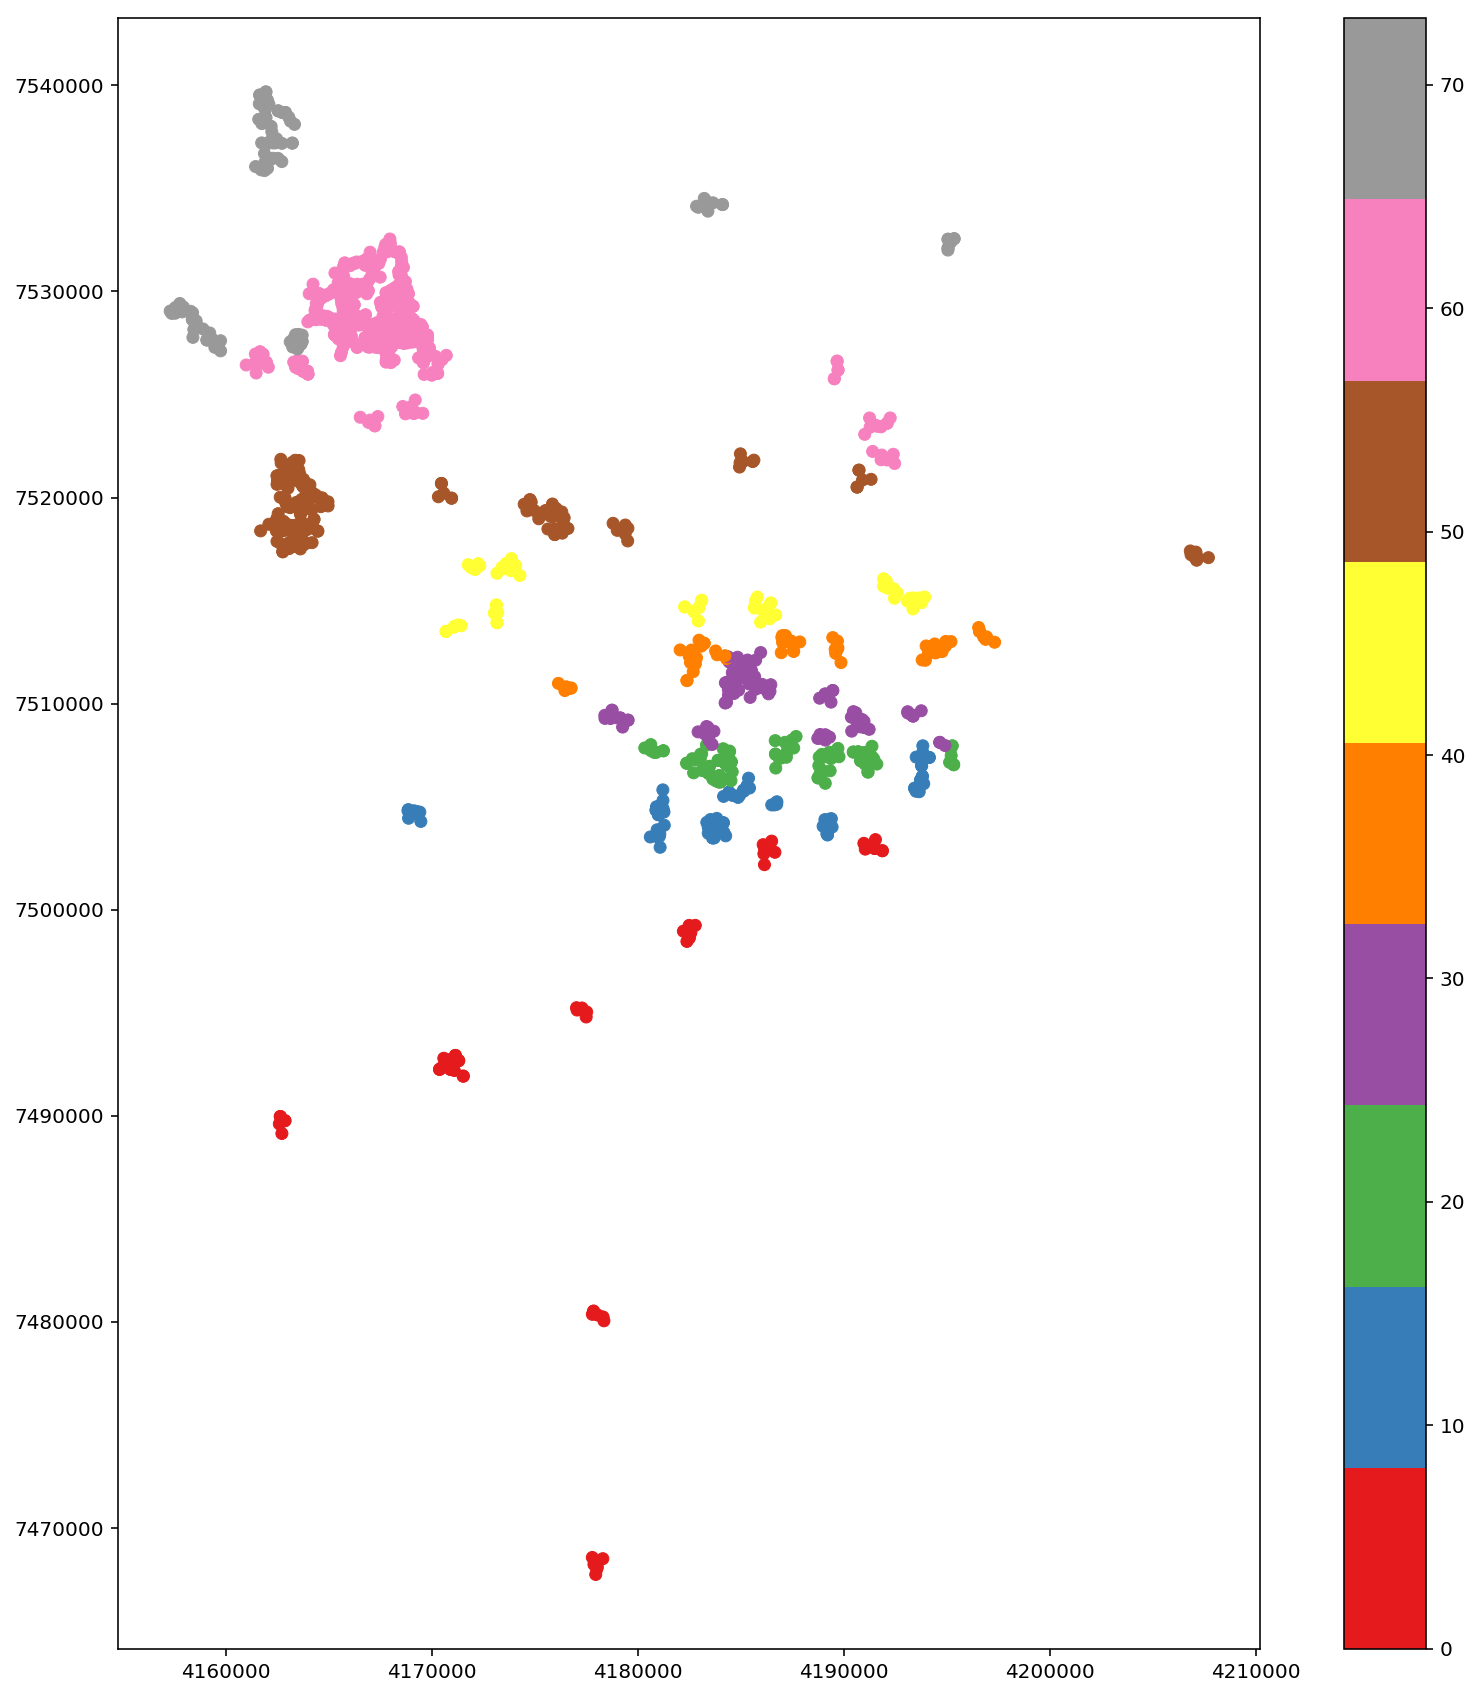

In [34]:
mask = (gdf_gps.cluster_number != -1)

gdf_gps[mask].plot(column = 'cluster_number', 
             linewidth=0.5, 
             cmap = 'Set1',
             #color = next(cycol),
             legend=True, figsize=[15,15])

In [35]:
print ('доля классифицированных объектов', gdf_gps[mask].shape[0] / gdf_gps.shape[0])

доля классифицированных объектов 0.39211688752973156


# Блок не доделал

In [36]:
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

In [37]:
clusters[0]

array([[55.541825, 37.531226],
       [55.54317 , 37.531684],
       [55.543644, 37.531927],
       [55.544285, 37.530445],
       [55.545716, 37.534316],
       [55.546022, 37.529744]])

In [38]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [39]:
# find the point in each cluster that is closest to its centroid
centermost_points = clusters.map(get_centermost_point)

In [40]:
centermost_points[:5]

0    (55.543644, 37.531927)
1     (55.60576, 37.532098)
2     (55.653583, 37.39576)
3    (55.668346, 37.471488)
4    (55.666203, 37.463134)
dtype: object

In [41]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lons':lons, 'lats':lats})
rep_points.tail()

,lats,lons
69,55.879071,37.579412
70,55.888493,37.388197
71,55.893692,37.392149
72,55.902252,37.386427
73,55.900749,37.395931


In [42]:
# pull row from original data set where lat/lon match the lat/lon of each row of representative points
rs = rep_points.apply(lambda row: df_gps[(df_gps['lat']==row['lats']) & (df_gps['lon']==row['lons'])].iloc[0], axis=1)

rs.head(5)

#combine the clustered and sampled sets
df_combined = pd.concat([rs, df_gps], axis=0)
df_combined = df_combined.reset_index().drop(labels='index', axis=1)

df_combined.head(2)

cluster_numbers = []

for i in range(0,len(clusters)-1):
    cluster_numbers.append(i)
    alt_cluster, lon_cluster = zip(*clusters[i])

#rs['cluster_number'] = cluster_numbers

# Выведем карту и маркеры

In [44]:
#https://github.com/vgm64/gmplot
#библиотека глючная, то работает то нет 
#IndexError: list index out of range
#запустить строчку выше, и вернуться на эту (или interrupt  и снова выполнить ячейку)

from gmplot import gmplot

# Place map
gmap = gmplot.GoogleMapPlotter.from_geocode("Moscow", 10)

#выведем маркеры кластеров (не сделал)
#for i in range(0, gdf_gps.shape[0]):
#    gmap.marker(gdf_gps['lat'][i], gdf_gps['lon'][i], color = 'green')

#gmap.scatter(top_attraction_lats, top_attraction_lons, '#3B0B39', size=40, marker=False)

#

from itertools import cycle
cycol = cycle('bgrcmk')

for n in range(0, len(clusters)-1):
    latt, lonn = zip(*clusters[n])
    gmap.scatter(latt, lonn, color = next(cycol), size=150, marker=False)

# Draw
gmap.draw("my_map.html")


# Стандаритизируем значения

In [45]:
from sklearn.preprocessing import StandardScaler

In [46]:
df_gps_kmean = pd.DataFrame(df_gps, columns=['lat', 'lon' ])

In [47]:
columns = df_gps_kmean.columns

In [48]:
columns

Index(['lat', 'lon'], dtype='object')

In [49]:
scaler = StandardScaler()

In [50]:
scaler.fit(df_gps_kmean)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [51]:
X_scaled = scaler.transform(df_gps_kmean)
X_scaled = pd.DataFrame(X_scaled, columns=columns)

In [52]:
X_scaled.head()

,lat,lon
0,-3.527494,0.145500
1,-3.502957,0.210970
2,-3.482560,0.170048
3,-3.422506,0.183172
4,-3.399013,0.091897


# Разбиваем на кластеры

In [53]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [54]:
k_mean_model = KMeans(n_clusters=108)
gdf_gps['clusters_kmean'] = k_mean_model.fit_predict(X_scaled)

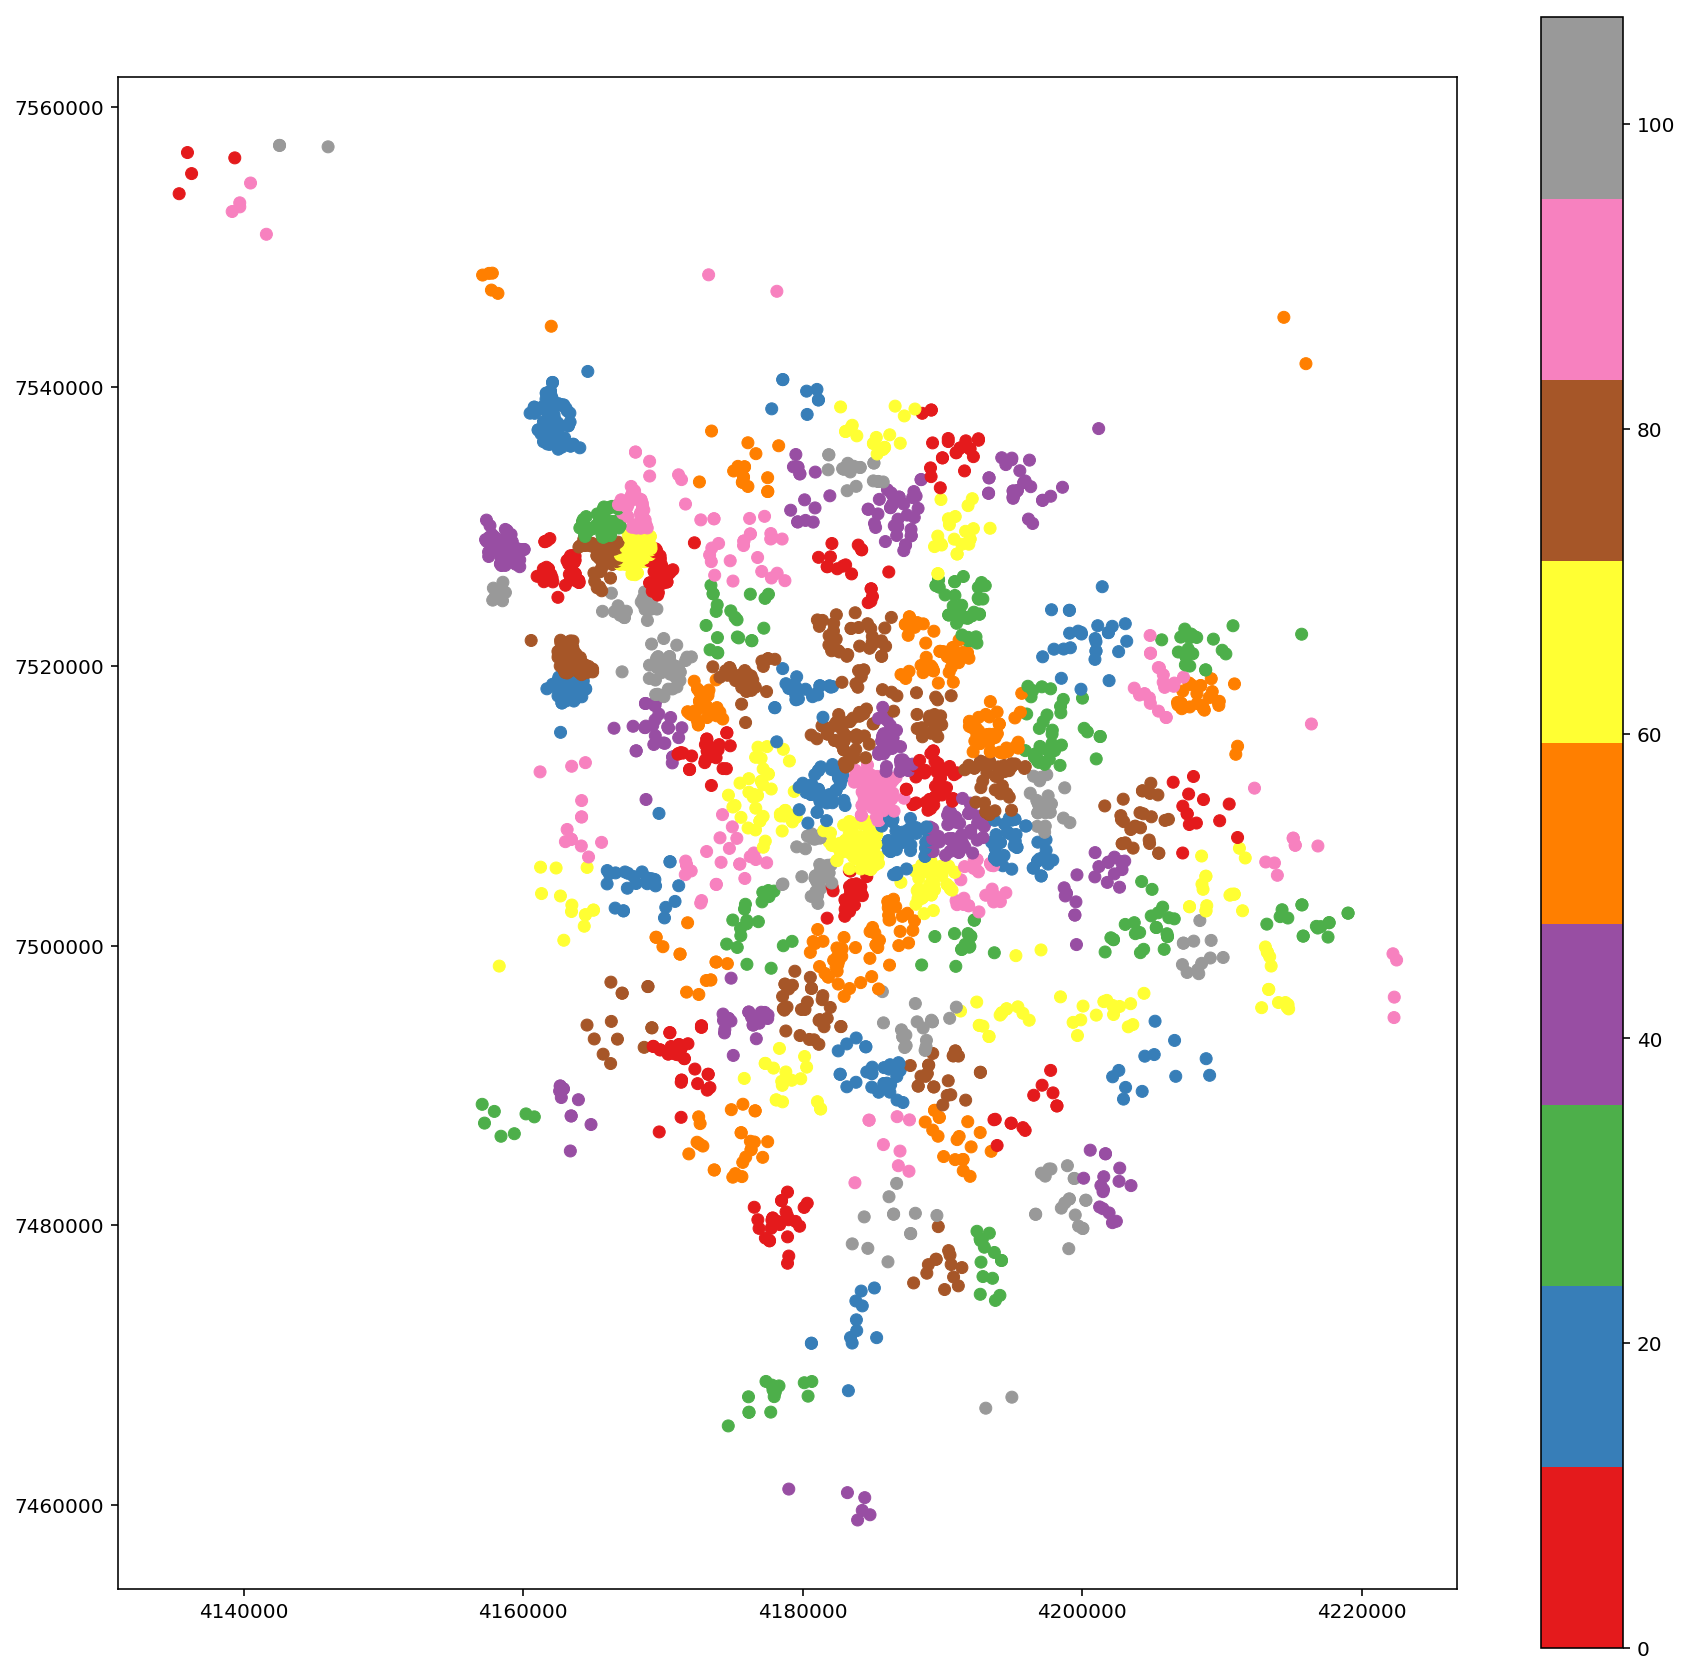

In [55]:
gdf_gps.plot(column = 'clusters_kmean', 
             linewidth=0.5, 
             cmap = 'Set1',
             #color = next(cycol),
             legend=True, figsize=[15,15])

# вывод на карту не получился

In [56]:
#нужно найти нормальную библиотеку для визуализации данных

# найдем оптимальное число кластеров K-means

In [57]:
import tqdm

k_inertia = []
ks = range(100,180)

for k in tqdm.tqdm(ks):
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled, )
    k_inertia.append(clf_kmeans.inertia_)

100%|██████████| 80/80 [01:15<00:00,  1.06it/s]


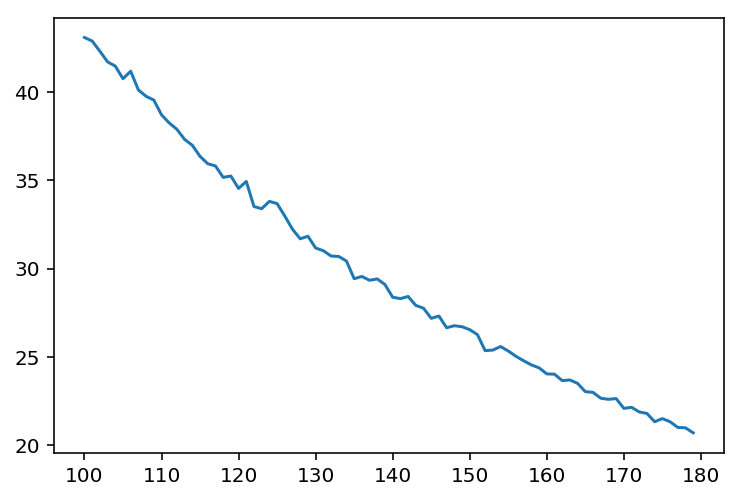

In [58]:
plt.plot(ks, k_inertia)

In [59]:
diff = np.diff(k_inertia)

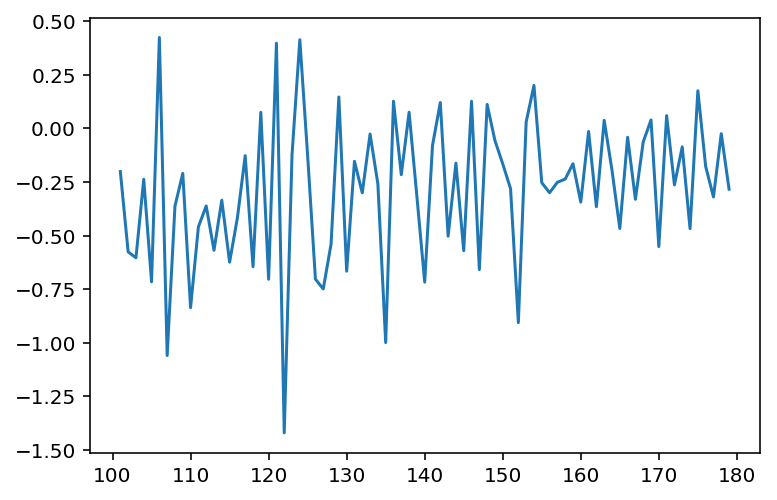

In [60]:
plt.plot(ks[1:], diff)

In [61]:
diff_r = diff[1:] / diff[:-1]

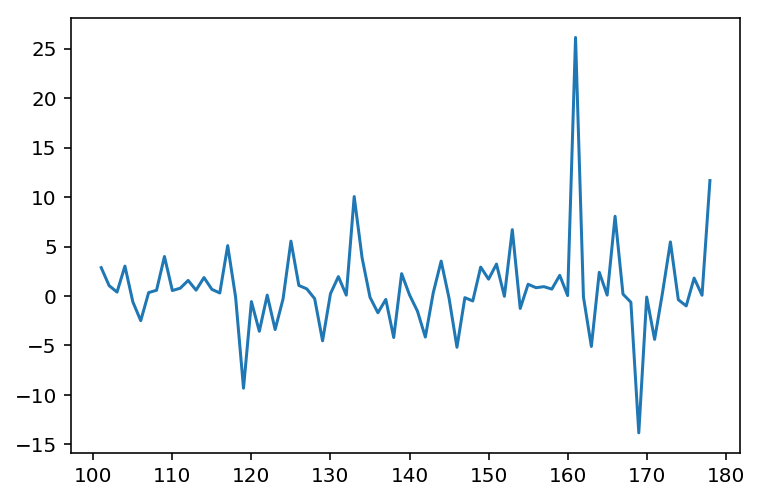

In [62]:
plt.plot(ks[1:-1], diff_r)

In [63]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

169

In [64]:
#можно еще попробовать другие значения
#различные запуски выдают различные значения :)

# Попробовал ГеоКодер,

In [65]:
#https://github.com/DenisCarriere/geocoder
#может пригодиться если парсить например GPS коодинаты из адресов
#бесплатное API яндекса на 25000 запросов в сутки

import geocoder 

In [66]:
#геокодеры часто возвращают ошибки, написал функцию чтобы это учесть
def geo_code (str):
    try:
        g = geocoder.yandex(str, lang = 'ru-Ru')
        return g
    except:
        return 'NaN'

In [67]:
yandex_geo = geocoder.yandex([55.738982, 37.603298], method='reverse', lang = 'ru-Ru')

In [68]:
yandex_geo.address

'Россия, Москва, 1-й Зачатьевский переулок, 5'

In [69]:
res = geo_code('1-й Зачатьевский пер 5 Мск ')

In [70]:
res[0]

[Россия, Москва, 1-й Зачатьевский переулок, 5]